In [1]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf

2023-06-04 16:20:08.813763: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dev = qml.device('default.mixed', wires=3)

In [3]:
def real():
    qml.Rot( 0.0,np.pi/2, np.pi/6,wires=0)

In [4]:
print(qml.draw(real)())

0: ──Rot(0.00,1.57,0.52)─┤  


In [5]:
def generator(w,**kwargs):
    qml.RX(w[0], wires=1)
    qml.RX(w[1], wires=2)
    qml.RY(w[2], wires=1)
    qml.RY(w[3], wires=2)
    qml.RZ(w[4], wires=1)
    qml.RZ(w[5], wires=2)
    qml.CNOT(wires=[1,2])
    qml.RX(w[6], wires=1)
    qml.RY(w[7], wires=1)
    qml.RZ(w[8], wires=1)
    qml.Rot(0.0, np.pi/2, -np.pi/6,wires=1)
    
# Not that it is nosiy since the generator is 2 qubit circuit while we only consider one of its qubit.    

In [6]:
print(qml.draw(generator)([ 0,0,0,0,0,0,0,0,0]))

1: ──RX(0.00)──RY(0.00)──RZ(0.00)─╭●──RX(0.00)──RY(0.00)──RZ(0.00)──Rot(0.00,1.57,-0.52)─┤  
2: ──RX(0.00)──RY(0.00)──RZ(0.00)─╰X─────────────────────────────────────────────────────┤  


In [7]:
def discriminator(w):
    qml.Hadamard(wires=0)
    qml.CZ(wires=[1, 0])
    qml.RZ(w[0], wires=0)
    qml.RZ(w[1], wires=1)
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)

In [8]:
print(qml.draw(discriminator)([ 0,1]))

0: ──H─╭Z──RZ(0.00)──H─┤  
1: ────╰●──RZ(1.00)──H─┤  


In [9]:
@qml.qnode(dev, interface='tf')
def real_gen_disc_circuit(gen_weights,disc_weights):
    real()
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval((qml.Identity(0)-qml.PauliZ(0))@ (qml.Identity(1)-qml.PauliZ(1)))

In [10]:
print(qml.draw(real_gen_disc_circuit)([ 0,0,0,0,0,0,0,0,0],[ 0,1]))

0: ──Rot(0.00,1.57,0.52)──H────────────────────────────────────────────────────────────────────────
1: ──RX(0.00)─────────────RY(0.00)──RZ(0.00)─╭●──RX(0.00)──RY(0.00)──RZ(0.00)──Rot(0.00,1.57,-0.52)
2: ──RX(0.00)─────────────RY(0.00)──RZ(0.00)─╰X────────────────────────────────────────────────────

──╭Z──RZ(0.00)──H─┤ ╭<𝓗>
──╰●──RZ(1.00)──H─┤ ╰<𝓗>
──────────────────┤     


In [11]:
def prob_discriminated(gen_weights,disc_weights):
    discriminated_output = real_gen_disc_circuit(gen_weights,disc_weights)
    #convert to probability
    prob_discriminated_output = (discriminated_output)/4
    return prob_discriminated_output

In [12]:
def disc_cost(disc_weights):
    cost = 1-prob_discriminated(gen_weights,disc_weights)
    return cost
def gen_cost(gen_weights):
    cost = prob_discriminated(gen_weights,disc_weights)
    return cost

In [13]:
@qml.qnode(dev, interface="tf")
def circuit_gs(angles):
    generator(angles)
    return qml.state()
@qml.qnode(dev, interface="tf")
def circuit_rs():
    real()
    return qml.state()

In [14]:
np.random.seed(0)
eps = 1e-2
    
init_gen_weights = np.array([0]*9)
#init_disc_weights = np.random.normal(size=(2,))
init_disc_weights = np.array([0]*2)
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)

2023-06-04 16:20:21.738878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
real_gen_disc_circuit(gen_weights, disc_weights)
prob_discriminated(gen_weights,disc_weights)

<tf.Tensor: shape=(), dtype=float64, numpy=0.12499999999999989>

In [16]:
loss_val_d = []
loss_val_g = []
step_d = []
step_g = []
sg =[]
epochs = 10
for i in range(epochs): 
    opt = tf.keras.optimizers.experimental.SGD(learning_rate=0.4)
    var = disc_weights
    loss = lambda: disc_cost(disc_weights)         # d(loss)/d(var1) = var1
    for step in range(50):
        opt.minimize(loss, [var])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_d.append(loss_val)
            step_d.append(step)
            print("Step {}: cost = {}".format(step, loss_val)) 
            
    opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    for step in range(50):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step_g.append(step)
            print("Step {}: cost = {}".format(step, loss_val))
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[0])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[1])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity)                    

Step 0: cost = 0.8558049713157225
Step 5: cost = 0.739220159087902
Step 10: cost = 0.6248777950887375
Step 15: cost = 0.5529201802938395
Step 20: cost = 0.5199710335315371
Step 25: cost = 0.5071704169995893
Step 30: cost = 0.5025264048150462
Step 35: cost = 0.5008841402205575
Step 40: cost = 0.5003086762730236
Step 45: cost = 0.5001076769486349
Step 0: cost = 0.49994390814871903
Step 5: cost = 0.4998545358630938
Step 10: cost = 0.4996228627143068
Step 15: cost = 0.49902287265183765
Step 20: cost = 0.4974727524778104
Step 25: cost = 0.4934927368406963
Step 30: cost = 0.48343528709936445
Step 35: cost = 0.4590154296226623
Step 40: cost = 0.40511627717445603
Step 45: cost = 0.30810661269480893
Step 0: cost = 0.7656862444299921
Step 5: cost = 0.6462964625408039
Step 10: cost = 0.5643086815708618
Step 15: cost = 0.524701587364603
Step 20: cost = 0.5089314951284163
Step 25: cost = 0.5031550173427038
Step 30: cost = 0.5011051393882472
Step 35: cost = 0.500385956603081
Step 40: cost = 0.500134

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g)), loss_val_g, label="Generator loss-min")
plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [18]:
obs0 = [qml.PauliX(0), qml.PauliY(0), qml.PauliZ(0)]
obs1 = [qml.PauliX(1), qml.PauliY(1), qml.PauliZ(1)]

@qml.qnode(dev, interface="tf")
def bloch_vector_real():
    real()
    return [qml.expval(o) for o in obs0]

@qml.qnode(dev, interface="tf")
def bloch_vector_generator(angles):
    generator(angles)
    return [qml.expval(o) for o in obs1]

print(f"Real Bloch vector: {bloch_vector_real()}")
print()
print(f"Generator Bloch vector: {bloch_vector_generator(var_g)}")

Real Bloch vector: [tensor(0.8660254, requires_grad=True), tensor(0.5, requires_grad=True), tensor(1.11022302e-16, requires_grad=True)]

Generator Bloch vector: [<tf.Tensor: shape=(), dtype=float64, numpy=0.06517303223288129>, <tf.Tensor: shape=(), dtype=float64, numpy=-0.9959960646294657>, <tf.Tensor: shape=(), dtype=float64, numpy=-0.06119080904996144>]


In [19]:
@qml.qnode(dev, interface="tf")
def circuit_gs(angles):
    generator(angles)
    return qml.state()

@qml.qnode(dev, interface="tf")
def circuit_rs():
    real()
    return qml.state()

red_r = qml.math.reduced_dm(circuit_rs(),indices=[0])
red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[1])
state_fidelity = qml.math.fidelity(red_r, red_g)
print(state_fidelity)

tf.Tensor(0.27922174068030015, shape=(), dtype=float64)


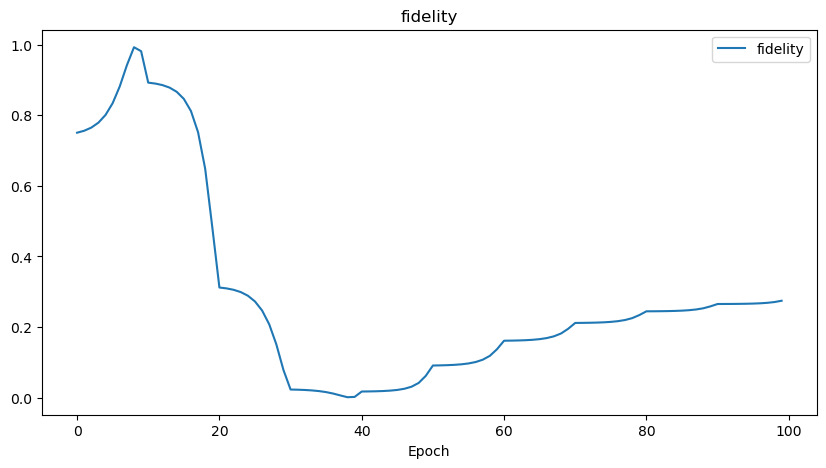

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g)), sg, label="fidelity")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("fidelity")
plt.xlabel("Epoch")
plt.legend()
plt.show()